In [ ]:
# Loading libraries for the course
from skimage import io as ski_io
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
import skimage as ski
from matplotlib import animation            # Module to plot animations
from skimage.filters import difference_of_gaussians
from skimage import io, measure               # Module from skimage
from cellpose import models

Cell size, area, 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as ski_io
from cellpose import models
import pandas as pd

# Load the image
figName = './Drug2_1000nM/rep1_FOV1.tif'
img = ski_io.imread(figName)

# Initialize Cellpose models
model_cyto = models.Cellpose(gpu=False, model_type='cyto')
model_nuclei = models.Cellpose(gpu=False, model_type='nuclei')

# Create an empty DataFrame to store results
df_merged_all_frames = pd.DataFrame(columns=['time', 'cell_ID', 'sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei', 'cell sizes', 'nucleus sizes'])

# Iterate over frames

for selected_frame in range(len(img)):
    # Select the appropriate frame and color channel
    img_to_analyze = img[selected_frame, :, :, 1]  # Assuming channel 1 for cytoplasm detection

    # Run Cellpose for cytoplasm detection
    masks_cyto, _, _, _ = model_cyto.eval(img_to_analyze, diameter=None, channels=[0, 0])

    if selected_frame == 0:
        mask_initial_cyto = masks_cyto

    masks_cyto = np.where(masks_cyto != 0, (masks_cyto * mask_initial_cyto) / masks_cyto, 0)
    
    # Prepare data for the cytoplasm DataFrame
    data_cyto = []
    for cell_id in np.unique(masks_cyto):
        mask = masks_cyto == cell_id
        sum_pix_intensity = img_to_analyze[mask].sum()
        cell_sizes = np.sum(mask)

        data_cyto.append([selected_frame, cell_id, sum_pix_intensity, cell_sizes])

    df_cyto = pd.DataFrame(data_cyto, columns=['time', 'cell_ID', 'sum_pix_intensity_cyto', 'cell sizes'])

    img_to_analyze = img[selected_frame, :, :, 0]  # Assuming channel 0 for nuclei detection

    # Run Cellpose for nuclei detection
    masks_nuclei, _, _, _ = model_nuclei.eval(img_to_analyze, diameter=None, channels=[0, 0])

    if selected_frame == 0:
        mask_initial_nuclei = masks_nuclei
        

    masks_nuclei = np.where(masks_nuclei != 0, (masks_nuclei * mask_initial_nuclei) / masks_nuclei, 0)

    # Prepare data for the nuclei DataFrame
    data_nuclei = []
    for cell_id in np.unique(masks_nuclei):
        mask = masks_nuclei == cell_id
        nucleus_sizes = np.sum(mask)
        sum_pix_intensity = img_to_analyze[mask].sum()

        data_nuclei.append([selected_frame, cell_id, nucleus_sizes, sum_pix_intensity])

    df_nuclei = pd.DataFrame(data_nuclei, columns=['time', 'cell_ID', 'nucleus sizes', 'sum_pix_intensity_nuclei'])

    # Merge the Cytoplasm and Nuclei DataFrames based on the 'cell' column
    df_merged = pd.merge(df_cyto, df_nuclei, on='cell_ID')
    df_merged['time'] = df_merged['time_x']
    df_merged = df_merged.drop(columns=['time_x', 'time_y'])
    df_merged = df_merged[['time', 'cell_ID', 'sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei', 'cell sizes', 'nucleus sizes']]
    df_merged['protein concentrations (AU)'] = (df_merged['sum_pix_intensity_cyto'] - df_merged['sum_pix_intensity_nuclei']) / (df_merged['cell sizes'] - df_merged['nucleus sizes'])

    # Concatenate DataFrames instead of using append
    frames = [df_merged_all_frames, df_merged]
    df_merged_all_frames = pd.concat(frames, ignore_index=True)
    df_merged_all_frames = df_merged_all_frames[df_merged_all_frames['cell_ID'] != 0]

    

# Display the merged DataFrame for all frames
print("Merged DataFrame for all frames:")
print(df_merged_all_frames)

Basic analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as ski_io
from skimage.filters import difference_of_gaussians
from skimage import measure
from cellpose import models
import pandas as pd

# Load the image
figName = './Drug2_1000nM/rep1_FOV1.tif'
img = ski_io.imread(figName)

# Initialize Cellpose models
model_cyto = models.Cellpose(gpu=False, model_type='cyto')
model_nuclei = models.Cellpose(gpu=False, model_type='nuclei')

# Create an empty DataFrame to store results
df_merged_all_frames = pd.DataFrame(columns=['time', 'cell_ID', 'sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei', 'cell sizes', 'nucleus sizes', 'Particles in cytosol', 'Particles in nucleus'])

# Iterate over frames
for selected_frame in range(len(img)):
    # Select the appropriate frame and color channel
    img_to_analyze = img[selected_frame, :, :, 1]  # Assuming channel 1 for cytoplasm detection

    # Run Cellpose for cytoplasm detection
    masks_cyto, _, _, _ = model_cyto.eval(img_to_analyze, diameter=None, channels=[0, 0])

    if selected_frame == 0:
        mask_initial_cyto = masks_cyto

    masks_cyto = np.where(masks_cyto != 0, (masks_cyto * mask_initial_cyto) / masks_cyto, 0)
    
    # Prepare data for the cytoplasm DataFrame
    data_cyto = []
    for cell_id in np.unique(masks_cyto):
        if cell_id == 0:
            continue  # Skip background
        mask = masks_cyto == cell_id
        sum_pix_intensity = img_to_analyze[mask].sum()
        cell_sizes = np.sum(mask)

        data_cyto.append([selected_frame, cell_id, sum_pix_intensity, cell_sizes])

    df_cyto = pd.DataFrame(data_cyto, columns=['time', 'cell_ID', 'sum_pix_intensity_cyto', 'cell sizes'])

    img_to_analyze = img[selected_frame, :, :, 0]  # Assuming channel 0 for nuclei detection

    # Run Cellpose for nuclei detection
    masks_nuclei, _, _, _ = model_nuclei.eval(img_to_analyze, diameter=None, channels=[0, 0])

    if selected_frame == 0:
        mask_initial_nuclei = masks_nuclei

    masks_nuclei = np.where(masks_nuclei != 0, (masks_nuclei * mask_initial_nuclei) / masks_nuclei, 0)

    # Prepare data for the nuclei DataFrame
    data_nuclei = []
    for cell_id in np.unique(masks_nuclei):
        if cell_id == 0:
            continue  # Skip background
        mask = masks_nuclei == cell_id
        nucleus_sizes = np.sum(mask)
        sum_pix_intensity = img_to_analyze[mask].sum()

        data_nuclei.append([selected_frame, cell_id, nucleus_sizes, sum_pix_intensity])

    df_nuclei = pd.DataFrame(data_nuclei, columns=['time', 'cell_ID', 'nucleus sizes', 'sum_pix_intensity_nuclei'])

    # Merge the Cytoplasm and Nuclei DataFrames based on the 'cell' column
    df_merged = pd.merge(df_cyto, df_nuclei, on='cell_ID')
    df_merged['time'] = df_merged['time_x']
    df_merged = df_merged.drop(columns=['time_x', 'time_y'])
    df_merged = df_merged[['time', 'cell_ID', 'sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei', 'cell sizes', 'nucleus sizes']]
    df_merged['protein concentrations (AU)'] = (df_merged['sum_pix_intensity_cyto'] - df_merged['sum_pix_intensity_nuclei']) / (df_merged['cell sizes'] - df_merged['nucleus sizes'])

    # Concatenate DataFrames instead of using append
    frames = [df_merged_all_frames, df_merged]
    df_merged_all_frames = pd.concat(frames, ignore_index=True)
    df_merged_all_frames = df_merged_all_frames[df_merged_all_frames['cell_ID'] != 0]

    # Analyze RNA spots
    selected_color_channel = 2
    img_to_analyze = img[selected_frame, :, :, selected_color_channel]

    # Apply a difference of Gaussians filter to the image to enhance spots
    img_spots_filtered = difference_of_gaussians(img_to_analyze, low_sigma=1, high_sigma=5)
    
    # Apply a threshold to the image to create binary image
    threshold = 0.05
    img_spots_binary = np.where(img_spots_filtered >= threshold, 1, 0)

    spot_contours = measure.find_contours(img_spots_binary, 0.5)

    number_detected_cells = np.max(mask_initial_cyto)
    list_cytosol_particles = np.zeros(number_detected_cells)
    list_nuclear_particles = np.zeros(number_detected_cells)

    # Loop through the spot contours
    for contour in spot_contours:
        # Find the position of the particle
        posn = np.mean(contour, axis=0).astype(int)

        # Ensure the position is within the image bounds
        if posn[0] >= img_spots_binary.shape[0] or posn[1] >= img_spots_binary.shape[1]:
            continue
        
        # Check which cyto mask the particle is in
        cell_num = mask_initial_cyto[posn[0], posn[1]]
        if cell_num > 0:
            list_cytosol_particles[cell_num - 1] += 1

            # Check if the particle is also in the nucleus
            if mask_initial_nuclei[posn[0], posn[1]] == cell_num:
                list_nuclear_particles[cell_num - 1] += 1

        # Analyze RNA spots
        selected_color_channel = 2
        img_to_analyze = img[selected_frame, :, :, selected_color_channel]

        # Apply a difference of Gaussians filter to the image to enhance spots
        img_spots_filtered = difference_of_gaussians(img_to_analyze, low_sigma=1, high_sigma=5)
        
        # Apply a threshold to the image to create a binary image
        threshold = 0.05
        img_spots_binary = np.where(img_spots_filtered >= threshold, 1, 0)

        spot_contours = measure.find_contours(img_spots_binary, 0.5)

        number_detected_cells = np.max(mask_initial_cyto)
        list_cytosol_particles = np.zeros(number_detected_cells)
        list_nuclear_particles = np.zeros(number_detected_cells)

        # Loop through the spot contours
        for contour in spot_contours:
            # Find the position of the particle
            posn = np.mean(contour, axis=0).astype(int)

            # Ensure the position is within the image bounds
            if posn[0] >= img_spots_binary.shape[0] or posn[1] >= img_spots_binary.shape[1]:
                continue
            
            # Check which cyto mask the particle is in
            cell_num = mask_initial_cyto[posn[0], posn[1]]
            if cell_num > 0:
                list_cytosol_particles[cell_num - 1] += 1

                # Check if the particle is also in the nucleus
                if mask_initial_nuclei[posn[0], posn[1]] == cell_num:
                    list_nuclear_particles[cell_num - 1] += 1



        # Analyze transcription sites
        selected_color_channel = 2
        img_to_analyze = img[selected_frame, :, :, selected_color_channel]

        # Apply a difference of Gaussians filter to the image to enhance spots
        img_spots_filtered = difference_of_gaussians(img_to_analyze, low_sigma=1, high_sigma=5)
        
        # Apply a threshold to the image to create a binary image
        threshold = 0.09
        img_spots_binary = np.where(img_spots_filtered >= threshold, 1, 0)

        spot_contours = measure.find_contours(img_spots_binary, 0.5)

        number_detected_cells = np.max(mask_initial_cyto)
        list_transcription_sites = np.zeros(number_detected_cells)
        list_position_transcription_sites = np.zeros(number_detected_cells)

        # Loop through the spot contours
        for contour in spot_contours:
            # Find the position of the particle
            posn = np.mean(contour, axis=0).astype(int)

            # Ensure the position is within the image bounds
            if posn[0] >= img_spots_binary.shape[0] or posn[1] >= img_spots_binary.shape[1]:
                continue
            
            # Check which nuclei mask the particle is in
            cell_num = mask_initial_nuclei[posn[0], posn[1]]
            if cell_num > 0:
                list_transcription_sites[cell_num - 1] += 1
                #count the intensity of the transcription sites
                intensity_transcription_sites = img_to_analyze[posn[0], posn[1]]


            #create a list with the position of the transcription sites and number of transcription sites
            list_position_transcription_sites[cell_num - 1] += posn[0]
            list_position_transcription_sites[cell_num - 1] += posn[1]

                           

        

        # Add the number of particles to the merged DataFrame
        df_merged['Particles in cytosol'] = list_cytosol_particles[df_merged['cell_ID'].astype(int) - 1]
        df_merged['Particles in nucleus'] = list_nuclear_particles[df_merged['cell_ID'].astype(int) - 1]

        df_merged['Transcription sites'] = list_transcription_sites[df_merged['cell_ID'].astype(int) - 1]
        df_merged['Position transcription sites'] = list_position_transcription_sites[df_merged['cell_ID'].astype(int) - 1]

    # Add the number of particles to the merged DataFrame


    # Concatenate DataFrames instead of using append
    df_merged_all_frames = pd.concat([df_merged_all_frames, df_merged], ignore_index=True)
    df_merged_all_frames.dropna(inplace=True)





Main function

In [ ]:
import numpy as np
import pandas as pd
from skimage import measure
from skimage.filters import difference_of_gaussians
from cellpose import models

def DRUG_E(img, model_cyto, model_nuclei):
    # Create an empty DataFrame to store results
    df_merged_all_frames = pd.DataFrame(columns=[
        'time', 'cell_ID', 'sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei', 
        'cell sizes', 'nucleus sizes', 'Particles in cytosol', 'Particles in nucleus'
    ])

    transcription_data = []
    transcription_site_id = 1

    # Iterate over frames
    for selected_frame in range(len(img)):
        # Select the appropriate frame and color channel for cytoplasm detection
        img_to_analyze = img[selected_frame, :, :, 1]

        # Run Cellpose for cytoplasm detection
        masks_cyto, _, _, _ = model_cyto.eval(img_to_analyze, diameter=None, channels=[0, 0])

        if selected_frame == 0:
            mask_initial_cyto = masks_cyto

        masks_cyto = np.where(masks_cyto != 0, (masks_cyto * mask_initial_cyto) / masks_cyto, 0)
        
        # Prepare data for the cytoplasm DataFrame
        data_cyto = []
        for cell_id in np.unique(masks_cyto):
            if cell_id == 0:
                continue  # Skip background
            mask = masks_cyto == cell_id
            sum_pix_intensity = img_to_analyze[mask].sum()
            cell_sizes = np.sum(mask)

            data_cyto.append([selected_frame, cell_id, sum_pix_intensity, cell_sizes])

        df_cyto = pd.DataFrame(data_cyto, columns=['time', 'cell_ID', 'sum_pix_intensity_cyto', 'cell sizes'])

        # Select the appropriate frame and color channel for nuclei detection
        img_to_analyze = img[selected_frame, :, :, 0]

        # Run Cellpose for nuclei detection
        masks_nuclei, _, _, _ = model_nuclei.eval(img_to_analyze, diameter=None, channels=[0, 0])

        if selected_frame == 0:
            mask_initial_nuclei = masks_nuclei

        masks_nuclei = np.where(masks_nuclei != 0, (masks_nuclei * mask_initial_nuclei) / masks_nuclei, 0)

        # Prepare data for the nuclei DataFrame
        data_nuclei = []
        for cell_id in np.unique(masks_nuclei):
            if cell_id == 0:
                continue  # Skip background
            mask = masks_nuclei == cell_id
            nucleus_sizes = np.sum(mask)
            sum_pix_intensity = img_to_analyze[mask].sum()

            data_nuclei.append([selected_frame, cell_id, nucleus_sizes, sum_pix_intensity])

        df_nuclei = pd.DataFrame(data_nuclei, columns=['time', 'cell_ID', 'nucleus sizes', 'sum_pix_intensity_nuclei'])

        # Merge the Cytoplasm and Nuclei DataFrames based on the 'cell_ID' column
        df_merged = pd.merge(df_cyto, df_nuclei, on='cell_ID')
        df_merged['time'] = df_merged['time_x']
        df_merged = df_merged.drop(columns=['time_x', 'time_y'])
        df_merged = df_merged[['time', 'cell_ID', 'sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei', 'cell sizes', 'nucleus sizes']]
        df_merged['protein concentrations (AU)'] = (
            df_merged['sum_pix_intensity_cyto'] - df_merged['sum_pix_intensity_nuclei']
        ) / (df_merged['cell sizes'] - df_merged['nucleus sizes'])

        # Concatenate DataFrames
        df_merged_all_frames = pd.concat([df_merged_all_frames, df_merged], ignore_index=True)

        # Analyze RNA spots
        selected_color_channel = 2
        img_to_analyze = img[selected_frame, :, :, selected_color_channel]

        # Apply a difference of Gaussians filter to the image to enhance spots
        img_spots_filtered = difference_of_gaussians(img_to_analyze, low_sigma=1, high_sigma=5)
        
        # Apply a threshold to the image to create a binary image
        threshold = 0.05
        img_spots_binary = np.where(img_spots_filtered >= threshold, 1, 0)

        spot_contours = measure.find_contours(img_spots_binary, 0.5)

        number_detected_cells = np.max(mask_initial_cyto)
        list_cytosol_particles = np.zeros(number_detected_cells)
        list_nuclear_particles = np.zeros(number_detected_cells)

        # Loop through the spot contours
        for contour in spot_contours:
            # Find the position of the particle
            posn = np.mean(contour, axis=0).astype(int)

            # Ensure the position is within the image bounds
            if posn[0] >= img_spots_binary.shape[0] or posn[1] >= img_spots_binary.shape[1]:
                continue
            
            # Check which cyto mask the particle is in
            cell_num = mask_initial_cyto[posn[0], posn[1]]
            if cell_num > 0:
                list_cytosol_particles[cell_num - 1] += 1

                # Check if the particle is also in the nucleus
                if mask_initial_nuclei[posn[0], posn[1]] == cell_num:
                    list_nuclear_particles[cell_num - 1] += 1

                # Collect transcription site data
                transcription_data.append({
                    'Time' : selected_frame,
                    'Transcription_Site_ID': transcription_site_id,
                    'Cell_ID': cell_num,
                    'Position_X': posn[0],
                    'Position_Y': posn[1],
                    'Intensity': img_to_analyze[posn[0], posn[1]]
                })
                transcription_site_id += 1

        # Add the number of particles to the merged DataFrame
        df_merged['Particles in cytosol'] = list_cytosol_particles[df_merged['cell_ID'].astype(int) - 1]
        df_merged['Particles in nucleus'] = list_nuclear_particles[df_merged['cell_ID'].astype(int) - 1]

        # Concatenate DataFrames
        df_merged_all_frames = pd.concat([df_merged_all_frames, df_merged], ignore_index=True)
        df_merged_all_frames.dropna(inplace=True)

    # Create a DataFrame for transcription sites
    df_transcription_sites = pd.DataFrame(transcription_data)

    return df_merged_all_frames, df_transcription_sites






In [ ]:
img = ski_io.imread('./Drug2_1000nM/rep1_FOV1.tif')

# Load pre-trained Cellpose models
model_cyto = models.Cellpose(model_type='cyto')
model_nuclei = models.Cellpose(model_type='nuclei')

# Call the DRUG_E function
df_merged_all_frames, df_transcription_sites = DRUG_E(img, model_cyto, model_nuclei)

# Print the results
print("Merged DataFrame (Cell and RNA Spot Analysis):")
print(df_merged_all_frames.head())

print("\nTranscription Sites DataFrame:")
print(df_transcription_sites.head())

In [ ]:
import numpy as np
import pandas as pd
from skimage.filters import difference_of_gaussians
from skimage import measure

# Select the frame and color channel
selected_frame = 4
selected_color_channel = 2
img_to_analyze = img[selected_frame, :, :, selected_color_channel]

# Apply a difference of Gaussians filter to the image to enhance spots
img_spots_filtered = difference_of_gaussians(img_to_analyze, low_sigma=1, high_sigma=5)

# Apply a threshold to the image to create a binary image
threshold = 0.09
img_spots_binary = np.where(img_spots_filtered >= threshold, 1, 0)

# Find contours in the binary image
spot_contours = measure.find_contours(img_spots_binary, 0.5)

# Initialize lists to keep track of transcription sites and their details
number_detected_cells = np.max(mask_initial_cyto)
list_transcription_sites = np.zeros(number_detected_cells, dtype=int)
list_position_transcription_sites = [[] for _ in range(number_detected_cells)]
list_intensity_transcription_sites = [[] for _ in range(number_detected_cells)]

# Loop through the spot contours
for contour in spot_contours:
    # Find the position of the particle
    posn = np.mean(contour, axis=0).astype(int)
    
    # Ensure the position is within the image bounds
    if posn[0] >= img_spots_binary.shape[0] or posn[1] >= img_spots_binary.shape[1]:
        continue
        
    # Check which nuclei mask the particle is in
    cell_num = mask_initial_nuclei[posn[0], posn[1]]
    if cell_num > 0:
        list_transcription_sites[cell_num - 1] += 1
        list_position_transcription_sites[cell_num - 1].append(posn)
        intensity_transcription_sites = img_to_analyze[posn[0], posn[1]]
        list_intensity_transcription_sites[cell_num - 1].append(intensity_transcription_sites)

# Create a list of dictionaries to construct the DataFrame
transcription_data = []
transcription_site_id = 1
for cell_id in range(number_detected_cells):
    for posn, intensity in zip(list_position_transcription_sites[cell_id], list_intensity_transcription_sites[cell_id]):
        transcription_data.append({
            'Transcription_Site_ID': transcription_site_id,
            'Cell_ID': cell_id + 1,
            'Position_X': posn[0],
            'Position_Y': posn[1],
            'Intensity': intensity
        })
        transcription_site_id += 1

# Create a DataFrame from the list of dictionaries
df_transcription_sites = pd.DataFrame(transcription_data)

Counting all images

In [ ]:
# Load all images and process them
image_directory = r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\Drug2_1000nM'
image_files = os.listdir(image_directory)
df_Drug2_1000nM = pd.DataFrame()

for image_file in image_files:
    if image_file.endswith('.tif'):
        image_path = os.path.join(image_directory, image_file)
        img = ski_io.imread(image_path)
        df_image = DRUG_E(img, model_cyto, model_nuclei)
        df_image['image_name'] = image_file
        df_Drug2_1000nM = pd.concat([df_Drug2_1000nM, df_image], ignore_index=True)

# Save the merged DataFrame to a CSV file
csv_file_path = 'df_Drug2_1000nM .csv'
df_all_images.to_csv(csv_file_path, index=False)


In [ ]:
image_directory = r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\Drug6_1000nM'
image_files = os.listdir(image_directory)
df_Drug6_1000nM = pd.DataFrame()

for image_file in image_files:
    if image_file.endswith('.tif'):
        image_path = os.path.join(image_directory, image_file)
        img = ski_io.imread(image_path)
        df_image = DRUG_E(img, model_cyto, model_nuclei)
        df_image['image_name'] = image_file
        df_Drug6_1000nM = pd.concat([df_Drug6_1000nM, df_image], ignore_index=True)

# Save the merged DataFrame to a CSV file
csv_file_path = 'df_Drug6_1000nM .csv'
df_all_images.to_csv(csv_file_path, index=False)



In [ ]:
image_directory = r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\Drug7_1000nM'
image_files = os.listdir(image_directory)
df_Drug7_1000nM = pd.DataFrame()

for image_file in image_files:
    if image_file.endswith('.tif'):
        image_path = os.path.join(image_directory, image_file)
        img = ski_io.imread(image_path)
        df_image = DRUG_E(img, model_cyto, model_nuclei)
        df_image['image_name'] = image_file
        df_Drug7_1000nM = pd.concat([df_Drug7_1000nM, df_image], ignore_index=True)

# Save the merged DataFrame to a CSV file
csv_file_path = 'df_Drug7_1000nM .csv'
df_all_images.to_csv(csv_file_path, index=False)

Starts Stats analysis

In [1]:
import numpy as np
import scipy as sp
import sympy as sym
import matplotlib.pyplot as plt
import numpy.random as rng
import scipy.stats as stats
# Uncomment the following the first time if you do not have seaborn installed:
#!pip install seaborn
import seaborn as sns
from typing import Union # for code annotation


In [2]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data from CSV in file.
Drug2_1000nM = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug2_1000nM_DesignResults.csv')
Drug6_1000nM = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug6_1000nM_DesignResults.csv')
Drug7_1000nM = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug7_1000nM_DesignResults.csv')

No_Drug = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\NoDrug_DesignResults.csv')


In [3]:
# Display the first few rows of the data
print("Drug2_1000nM Data:")
print(Drug2_1000nM.head())


Drug2_1000nM Data:
       Cell_id  Rep_Num  FOV_Num  drug_time  drug_concentration  cell_Num  \
0  rep1_FOV1_1        1        1       1200                   1         1   
1  rep1_FOV1_1        1        1       1200                   1         1   
2  rep1_FOV1_1        1        1       1200                   1         1   
3  rep1_FOV1_1        1        1       1200                   1         1   
4  rep1_FOV1_1        1        1       1200                   1         1   

   Time  num_rna_cyto  num_rna_nuc  num_rna_nascent  Cyto_Intensity_1  \
0  1000            10            5                3              1761   
1  1050             9            0                0              1526   
2  1100             4            0               16              1158   
3  1150             4            3                8               862   
4  1200             5            5                2               672   

   is_cell_vital  
0              1  
1              1  
2              1  
3  

In [ ]:
# Create a line plot of time vs. number of RNA in nuclei per living cell

plt.figure(figsize=(10, 6))
sns.lineplot(data=Drug2_1000nM, x='Time', y='num_rna_nuc', label='Drug2_1000nM')
sns.lineplot(data=Drug6_1000nM, x='Time', y='num_rna_nuc', label='Drug6_1000nM')
sns.lineplot(data=Drug7_1000nM, x='Time', y='num_rna_nuc', label='Drug7_1000nM')
plt.xlabel('Time')
plt.ylabel('Number of RNA in Nuclei (Average)')
plt.title('Number of RNA in Nuclei Over Time')
plt.legend()
plt.show()


In [ ]:
# Create a line plot of time vs. AU per living cell

plt.figure(figsize=(10, 6))
sns.lineplot(data=Drug2_1000nM, x='Time', y='Cyto_Intensity_1', label='Drug2_1000nM')
sns.lineplot(data=Drug6_1000nM, x='Time', y='Cyto_Intensity_1', label='Drug6_1000nM')
sns.lineplot(data=Drug7_1000nM, x='Time', y='Cyto_Intensity_1', label='Drug7_1000nM')
plt.xlabel('Time')
plt.ylabel('AU concentration (Average)')
plt.title('Protein Concentration Over Time')
plt.legend()
plt.show()


In [ ]:
# Create a line plot of time vs. vitality per living cell



plt.figure(figsize=(10, 6))
sns.lineplot(data=Drug2_1000nM, x='Time', y='is_cell_vital', label='Drug2_1000nM')
sns.lineplot(data=Drug6_1000nM, x='Time', y='is_cell_vital', label='Drug6_1000nM')
sns.lineplot(data=Drug7_1000nM, x='Time', y='is_cell_vital', label='Drug7_1000nM')
plt.xlabel('Time')
plt.ylabel('Number of RNA in Cytoplasma (Average)')
plt.title('Number of RNA in Cytoplasma Over Time')
plt.legend()
plt.show()


In [ ]:
# Features to analyze
features = ['cell sizes', 'nucleus sizes', 'protein concentrations (AU)', 'Particles in cytosol', 'Particles in nucleus']

# Loop through each feature and perform ANOVA and Tukey's HSD test
for feature in features:
    print(f"\nAnalyzing {feature}...")
    
    # Perform one-way ANOVA
    groups = [df[df['time'] == time][feature].dropna() for time in time_points]
    f_statistic, p_value = f_oneway(*groups)
    print(f'F-statistic: {f_statistic}, p-value: {p_value}')
    
    # If significant, perform Tukey's HSD
    if p_value < 0.05:
        print(f"Significant differences found for {feature}. Performing Tukey's HSD post hoc test.")
        tukey_results = pairwise_tukeyhsd(df[feature], df['time'], alpha=0.05)
        print(tukey_results)
        tukey_results.plot_simultaneous()
        plt.show()
    else:
        print(f"No significant differences found for {feature}.")


1) Find the next Rxn (tau)
2) Find which is next Rxn (mu)
3) Update t += tau, x+=S(mu)

Algorithm 1 --> First Reaction Methods:
1a/1b) generate tau(i) for each i:
    tau=min[tau(i)]
    mu=argmin[tau(i)]

2) Update

Algorithm 2 -->

P(Tau(1) < Tau)= 1-e^(-w(1)Tau)
P(Tau(2) < Tau)= 1-e^(-w(2)Tau)

P(max(Tau(1),Tau(2)) < Tau ) = (1-e^(-w(1)Tau)) * (1-e^(-w(2)Tau)) #Jikini

P(Tau(1) > Tau) = e^(-w(1)Tau) = S1

P(Tau(2) > Tau) = e^(-w(2)Tau) = S2

P(Tau(1) > Tau AND Tau(2) > Tau) = P(min(Tau(1),Tau(2))>Tau) = e^(-w(1)Tau) * e^(-w(2)Tau)

S(1+2) = e^(-(w1+w2)*Tau)

P(min(Tau(1),Tau(2) < Tau)) = 1-e(-(w1+w2)*Tau)

f(min(Tau(1),Tau(2))) = -1/(w(1)+w(2)) * e^(-(w(1)+(w(2)))*Tau)

min(Tau(1),Tau(2)) ~ Exp (w1+w2)


1a/1b Generate:
    Tau ~ Exp (W1+W2+...)
    mu = 



In [4]:
import numpy as np
import scipy as sp
import sympy as sym
import matplotlib.pyplot as plt
import numpy.random as rng
import scipy.stats as stats
# Uncomment the following the first time if you do not have seaborn installed:
#!pip install seaborn
import seaborn as sns
from typing import Union # for code annotation

# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data from CSV in file.
Drug2_1000nM = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug2_1000nM_DesignResults.csv')
Drug6_1000nM = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug6_1000nM_DesignResults.csv')
Drug7_1000nM = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug7_1000nM_DesignResults.csv')

No_Drug = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\NoDrug_DesignResults.csv')


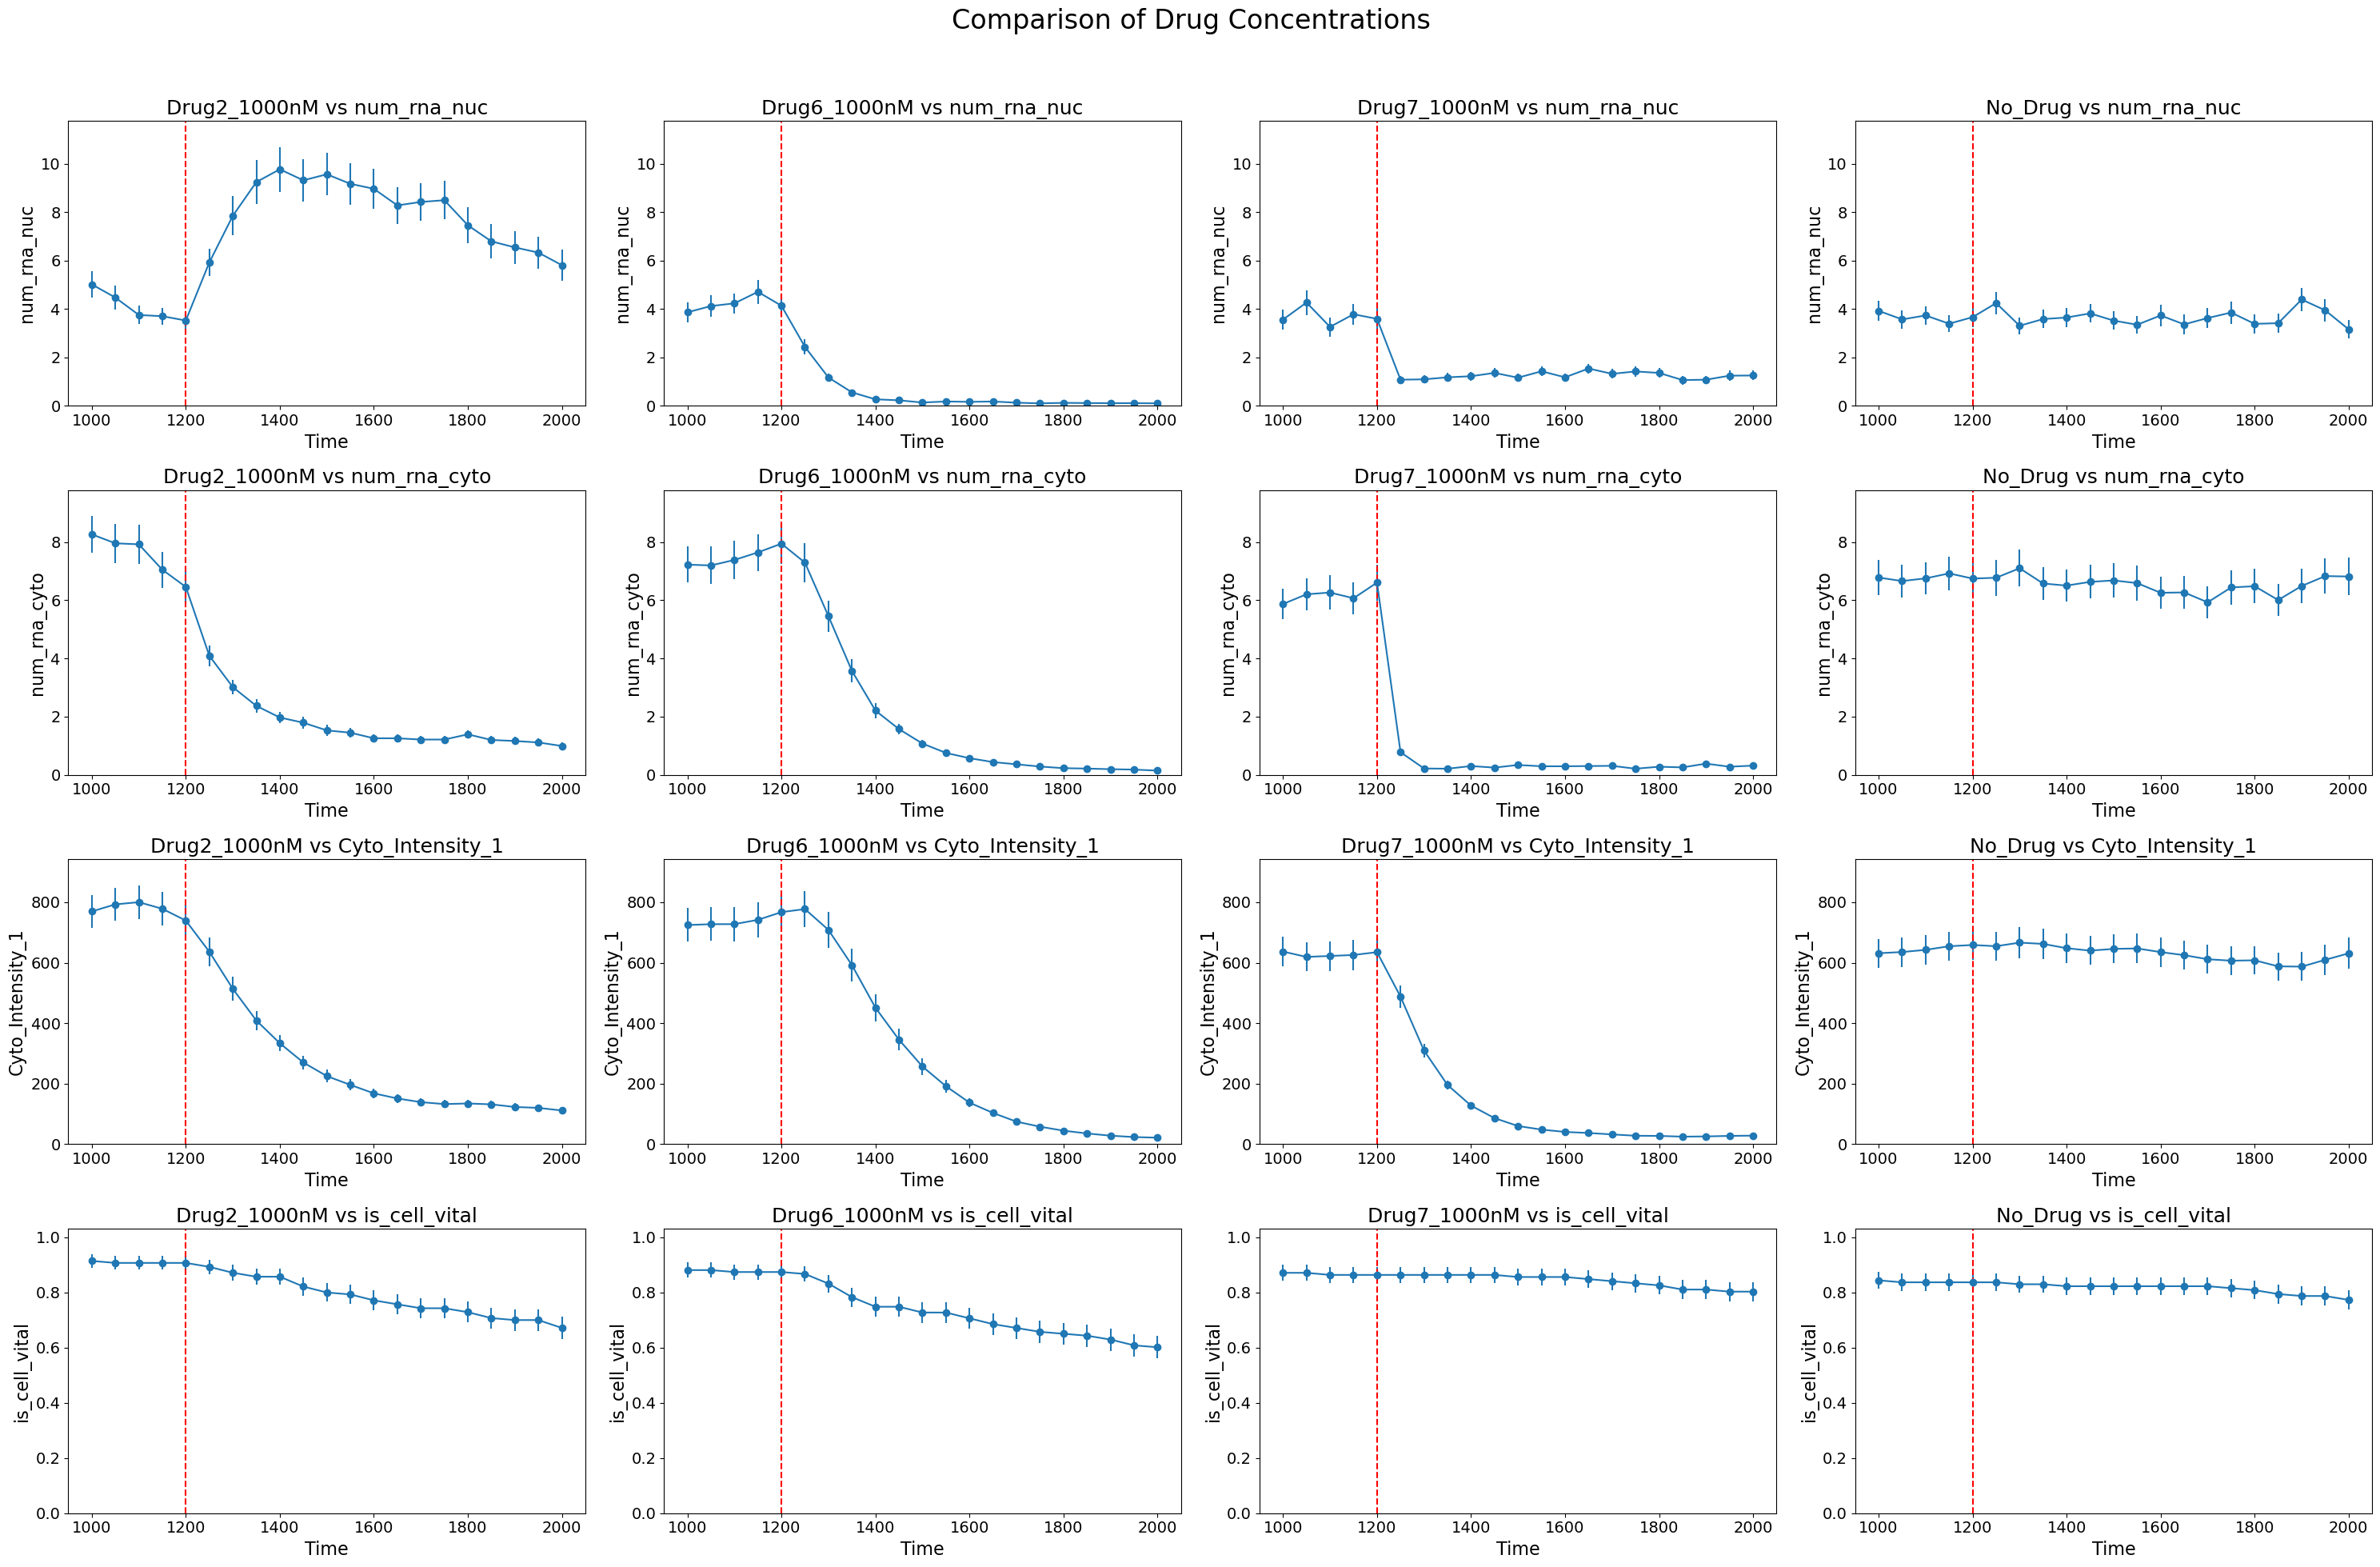

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# List of drug names (assuming drugs are arranged in order across 11 columns)
drug_names = ['Drug2_1000nM', 'Drug6_1000nM', 'Drug7_1000nM', 'No_Drug']

# List of y labels for each row
y_labels = ['num_rna_nuc', 'num_rna_cyto', 'Cyto_Intensity_1', 'is_cell_vital']

# Set the font size globally
plt.rcParams.update({'font.size': 14})

# Calculate global min and max for each y_label across all drugs
global_mins = {}
global_maxs = {}

for y_label in y_labels:
    global_min = np.inf
    global_max = -np.inf
    for drug in drug_names:
        drug_data = eval(drug)
        grouped = drug_data.groupby('Time')[y_label]
        means = grouped.mean()
        sems = grouped.sem()
        global_min = min(global_min, np.nanmin(means - sems))
        global_max = max(global_max, np.nanmax(means + sems))
    global_mins[y_label] = global_min
    global_maxs[y_label] = global_max

fig, axs = plt.subplots(len(y_labels), len(drug_names), figsize=(30, 20))
fig.suptitle('Comparison of Drug Concentrations', fontsize=24)

for i, drug in enumerate(drug_names):
    drug_data = eval(drug)
    for j, y_label in enumerate(y_labels):
        # Group by 'Time' and calculate mean and SEM
        grouped = drug_data.groupby('Time')[y_label]
        means = grouped.mean()
        sems = grouped.sem()

        times = means.index

        # Plot with error bars
        axs[j, i].errorbar(times, means, yerr=sems, fmt='-o')
        axs[j, i].axvline(x=1200, color='r', linestyle='--')  # Add vertical line at Time = 1200
        axs[j, i].set_title(f'{drug} vs {y_label}', fontsize=18)
        axs[j, i].set_xlabel('Time', fontsize=16)
        axs[j, i].set_ylabel(y_label, fontsize=16)
        axs[j, i].set_ylim([0, 1.1 * global_maxs[y_label]])  # Use global max for y-axis limit
        axs[j, i].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to make room for the title
plt.show()

# Model for Drug 2

In [6]:
# show head for Drug2_1000nM
print(No_Drug.head())

       Cell_id  Rep_Num  FOV_Num  drug_time  drug_concentration  cell_Num  \
0  rep1_FOV1_1        1        1        inf                   0         1   
1  rep1_FOV1_1        1        1        inf                   0         1   
2  rep1_FOV1_1        1        1        inf                   0         1   
3  rep1_FOV1_1        1        1        inf                   0         1   
4  rep1_FOV1_1        1        1        inf                   0         1   

   Time  num_rna_cyto  num_rna_nuc  num_rna_nascent  Cyto_Intensity_1  \
0  1000             2            3                8               399   
1  1050             4           13                8               352   
2  1100             7           12                1               432   
3  1150            11            6                2               637   
4  1200            11            2                1               882   

   is_cell_vital  
0              1  
1              1  
2              1  
3              1  
4  

In [519]:
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
from types import *
import matplotlib.animation as animation
from matplotlib import rc
import pandas as pd

rc('animation', html='jshtml')
figSize=600

# Let's define a simple function that computes the time of the next reaction given our propensity functions:
def next_time(x, t, W, pars=None):
    return -np.log(np.random.rand()) / np.sum(W(x, t, pars=pars))

# Let's define a simple function that computes the index of the next reaction given our propensity functions:
def next_reaction(x, t, W, pars, di, ti):
    W = W(x, t, pars=pars)
    W0 = np.sum(W)
    r = np.random.rand()
    i = 0
    W_sum = W[0]
    while W_sum / W0 < r:
        i += 1
        W_sum += W[i]
    return i

def gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj = False):
    # Initialize the time and the state
    t = t0
    x = np.array(x0)
    S = np.array(S)
    
    # Initialize the output (if requested)
    if returnFullTraj:
        times = [t0]
        states = [x0]
    
    # Run the simulation
    while t < tmax:

        # Compute the time of the next reaction
        tau = next_time(x, t, W, pars, di, ti)
        t += tau
        
        # Exit the loop if the next reaction is beyond tmax
        if t > tmax:
            break
        
        # Compute the index of the next reaction
        i = next_reaction(x, t, W, pars, di, ti)
        # Update the state
        x = x + S[:, i]
        
        # Append the results (if requested)
        if returnFullTraj:
            times.append(t)
            states.append(x)

    # Return the results
    if returnFullTraj:
        # Return the full trajectory
        return np.array(times), np.array(states)
    else:
        # Return only the final state
        return x
    
def dxdt(x, t, pars, di, ti):
    x = np.atleast_2d(x).T
    y = (S @ W(x, t, pars, di, ti, drug_number)).flatten()
    return y


def solve(S, W, x0, t, pars, di, ti, model='ODE', ntraj=1):

    if model == 'ODE':
        trajectory = odeint(dxdt,np.array(x0),t, args=(pars, di, ti))

    if model == 'SSA':
        trajectory = np.zeros([ntraj, len(t), len(x0)])
        t0 = t[0]
        tmax = t[-1]
        for i in range(ntraj):
            times,states = gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj=True)
            
            k = 0
            for j in range(len(times)):
                while times[j] > t[k]:
                    trajectory[i,k,:] = states[j]
                    k+=1

        trajectory = np.mean(trajectory, axis=0)
    return trajectory


def compare_model_to_data(pars,di,ti, x0, drug_number, speciesDict, drug_conc=1000, path='.', model='ODE', ntraj=10):
    #
    # example_df = pd.read_csv(r'C:\Users\wsraymon\Desktop\uqbio2024_challenge_solns\Data\Drug1_3000nM_DesignResults.csv')
    if drug_number == 0:
        example_df = pd.read_csv(path + '/NoDrug_DesignResults.csv' )
    else:
        example_df = pd.read_csv(path + '/Drug%i_%inM_DesignResults.csv'%(drug_number,drug_conc) )
    t = np.unique(example_df['Time'])
    t_app = example_df['drug_time'].iloc[0]
    data = np.zeros([5,len(t)])
    data_std = np.zeros([5,len(t)])
    k = 0
    for tp in t:
        subdf = example_df[example_df['Time'] == tp]
        subdf = subdf[subdf['is_cell_vital'] == 1]
        data[1,k] = np.mean(subdf['num_rna_nascent'])
        data[2,k] = np.mean(subdf['num_rna_nuc'])
        data[3,k] = np.mean(subdf['num_rna_cyto'])
        data[4,k] = np.mean(subdf['Cyto_Intensity_1'])

        data_std[1,k] = np.std(subdf['num_rna_nascent'])/np.sqrt(len(subdf['num_rna_nascent']))
        data_std[2,k] = np.std(subdf['num_rna_nuc'])/np.sqrt(len(subdf['num_rna_nuc']))
        data_std[3,k] = np.std(subdf['num_rna_cyto'])/np.sqrt(len(subdf['num_rna_cyto']))
        data_std[4,k] = np.std(subdf['Cyto_Intensity_1'])/np.sqrt(len(subdf['Cyto_Intensity_1']))
        k+=1

    fig,ax = plt.subplots(1,4, tight_layout=True, figsize=(10,4))
    ax[0].errorbar(t, data[1], yerr=data_std[1])
    ax[1].errorbar(t, data[2], yerr=data_std[2])
    ax[2].errorbar(t, data[3], yerr=data_std[3])
    ax[3].errorbar(t, data[4], yerr=data_std[4])

    ax[0].plot([t_app, t_app], [0, max(data[1])], 'r--', label='_nolegend_')
    ax[1].plot([t_app, t_app], [0, max(data[2])], 'r--', label='_nolegend_')
    ax[2].plot([t_app, t_app], [0, max(data[3])], 'r--', label='_nolegend_')
    ax[3].plot([t_app, t_app], [0, max(data[4])], 'r--', label='_nolegend_')

    ax[0].set_title('Nascent RNA')
    ax[1].set_title('Nuclear RNA')
    ax[2].set_title('Cytosolic RNA')
    ax[3].set_title('Protein (intensity)')

    s = solve(S, W, x0, np.linspace(0,2000,2001),pars, di, ti, model=model, ntraj=ntraj )

    ax[0].plot(np.linspace(0,2000,2001), s.T[speciesDict['Nascent']], )
    ax[1].plot(np.linspace(0,2000,2001), s.T[speciesDict['Nuclear']],)
    ax[2].plot(np.linspace(0,2000,2001), s.T[speciesDict['Cytoplasmic']],)
    ax[3].plot(np.linspace(0,2000,2001), s.T[speciesDict['Protein']],)

    ax[0].set_xlim([1000,2000])
    ax[1].set_xlim([1000,2000])
    ax[2].set_xlim([1000,2000])
    ax[3].set_xlim([1000,2000])

In [563]:
# Stoichiometry matrix
S = np.array([
    [-1, 1, 0, 0, 0, 0, 0, 0, 0, 0], # DNA_OFF to DNA_ON
    [1, -1, 0, 0, 0, 0, 0, 0, 0, 0], # DNA_ON to DNA_OFF
    [0, 0, 1, -1, 0, 0, 0, 0, 0, 0], # RNA_Nascent to RNA_Nuclear
    [0, 0, 0, 0, 1, -1, 0, 0, 0, 0], # RNA_Nuclear to RNA_Cytoplasmic
    [0, 0, 0, 0, 0, 0, 1, -1, 0, 0], # RNA_Cytoplasmic to Protein
    [0, 0, 0, 0, 0, 0, 0, 0, 1, -1]  # Protein to Degradation 
    ])

di = [0,100,0]
ti = [np.inf,1200,np.inf]

x0 = np.array([1,0,6.2,4.5,8,1000])


#params for the model 
pars = {'k0': 0.1, 'k1': 0.05, 
        'k2': 0.1, 'k3': 0.01, 
        'k4': 0.032, 'k5': 0.046, 
        'k6': 0.1, 'k7': 0.055, 
        'k8': 1.75, 'k9': 0.0185} 





speciesDict = {'Nascent':2, 'Nuclear':3, 'Cytoplasmic':4, 'Protein':5}  # how to map your species to the data 


import numpy as np


# Funkcja Hilla
def hill_function(concentration, Kd, n):
    return concentration**n / (Kd**n + concentration**n)

# Funkcja obliczająca wartości W
def W(x, t, pars, di, ti, drug_number):
    k0 = pars['k0']
    k1 = pars['k1']
    k2 = pars['k2']
    k3 = pars['k3']
    k4 = pars['k4']
    k5 = pars['k5']
    k6 = pars['k6']
    k7 = pars['k7']
    k8 = pars['k8']
    k9 = pars['k9']

    if drug_number == 0:
        W = np.array([
            k0 * x[0],  # DNA_OFF to DNA_ON
            k1 * x[1],  # DNA_ON to DNA_OFF
            k2 * x[1],  # DNA_ON to RNA_Nascent
            k3 * x[2],  # RNA_Nascent denature
            k4 * x[2],  # RNA_Nascent to RNA_Nuclear
            k5 * x[3],  # RNA_Nuclear denture
            k6 * x[3],  # RNA_Nuclear to RNA_Cytoplasmic
            k7 * x[4],  # RNA_Cytoplasmic denature
            k8 * x[4],  # RNA_Cytoplasmic to Protein
            k9 * x[5]   # Protein to Degradation
        ])
    elif drug_number == 2:
        hill_effect1 = hill_function(1000, 500, -0.2)
        hill_effect2 = hill_function(1000, 100, -10)

        W = np.array([
            k0 * x[0],  # DNA_OFF to DNA_ON
            k1 * x[1],  # DNA_ON to DNA_OFF
            k2 * x[1],  # DNA_ON to RNA_Nascent
            k3 * x[2],  # RNA_Nascent denature
            k4 * x[2],  # RNA_Nascent to RNA_Nuclear
            k5 * x[3] * (hill_effect1 if t >= ti[1] else 1),  # RNA_Nuclear denture
            k6 * x[3] * (hill_effect2 if t >= ti[1] else 1),  # RNA_Nuclear to RNA_Cytoplasmic
            k7 * x[4],  # RNA_Cytoplasmic denature
            k8 * x[4],  # RNA_Cytoplasmic to Protein
            k9 * x[5]   # Protein to Degradation
        ])
    elif drug_number == 4:
        hill_effect = hill_function(1000, 85, -0.8)
        W = np.array([
            k0 * x[0],  # DNA_OFF to DNA_ON
            k1 * x[1],  # DNA_ON to DNA_OFF
            k2 * x[1],  # DNA_ON to RNA_Nascent
            k3 * x[2],  # RNA_Nascent denature
            k4 * x[2],  # RNA_Nascent to RNA_Nuclear
            k5 * x[3],  # RNA_Nuclear denture
            k6 * x[3],  # RNA_Nuclear to RNA_Cytoplasmic
            k7 * x[4],  # RNA_Cytoplasmic denature
            k8 * x[4] * (hill_effect if t >= ti[1] else 1),  # RNA_Cytoplasmic to Protein
            k9 * x[5]   # Protein to Degradation
        ])

    elif drug_number == 6:
        hill_effect = hill_function(1000, 65, -0.8)
        W = np.array([
            k0 * x[0],  # DNA_OFF to DNA_ON
            k1 * x[1],  # DNA_ON to DNA_OFF
            k2 * x[1],  # DNA_ON to RNA_Nascent
            k3 * x[2],  # RNA_Nascent denature
            k4 * x[2] * (hill_effect if t >= ti[1] else 1),  # RNA_Nascent to RNA_Nuclear
            k5 * x[3],  # RNA_Nuclear denture
            k6 * x[3],  # RNA_Nuclear to RNA_Cytoplasmic
            k7 * x[4],  # RNA_Cytoplasmic denature
            k8 * x[4],  # RNA_Cytoplasmic to Protein
            k9 * x[5]   # Protein to Degradation
        ])
    elif drug_number == 7:
        hill_effect = hill_function(1000, 65, -0.8)
        W = np.array([
            k0 * x[0],  # DNA_OFF to DNA_ON
            k1 * x[1],  # DNA_ON to DNA_OFF
            k2 * x[1],  # DNA_ON to RNA_Nascent
            k3 * x[2],  # RNA_Nascent denature
            k4 * x[2] * (hill_effect if t >= ti[1] else 1),  # RNA_Nascent to RNA_Nuclear
            k5 * x[3],  # RNA_Nuclear denture
            k6 * x[3],  # RNA_Nuclear to RNA_Cytoplasmic
            k7 * x[4],  # RNA_Cytoplasmic denature
            k8 * x[4],  # RNA_Cytoplasmic to Protein
            k9 * x[5]   # Protein to Degradation
        ])
    elif drug_number == 10:
        hill_effect = hill_function(1000, 65, -0.5)
        W = np.array([
            k0 * x[0],  # DNA_OFF to DNA_ON
            k1 * x[1],  # DNA_ON to DNA_OFF
            k2 * x[1],  # DNA_ON to RNA_Nascent
            k3 * x[2],  # RNA_Nascent denature
            k4 * x[2],  # RNA_Nascent to RNA_Nuclear
            k5 * x[3],  # RNA_Nuclear denture
            k6 * x[3],  # RNA_Nuclear to RNA_Cytoplasmic
            k7 * x[4],  # RNA_Cytoplasmic denature
            k8 * x[4] * (hill_effect if t >= ti[1] else 1),  # RNA_Cytoplasmic to Protein
            k9 * x[5]   # Protein to Degradation
        ])
    return W



Drug 0
Drug 10
Drug 4
Drug 6
Drug 7
Drug 2


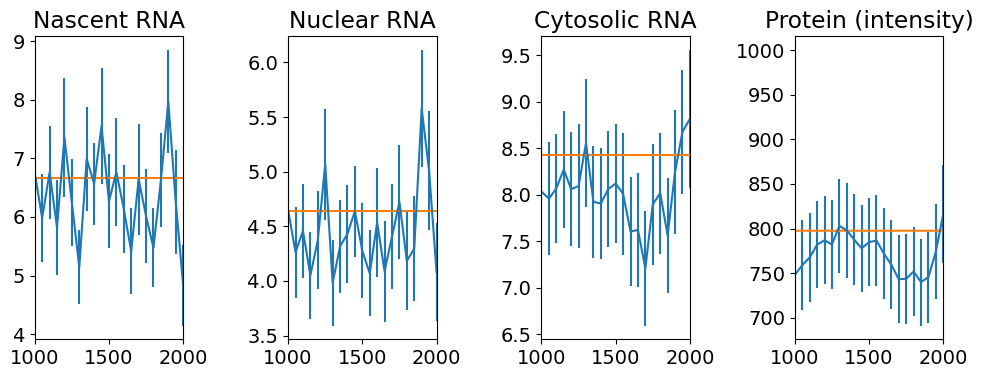

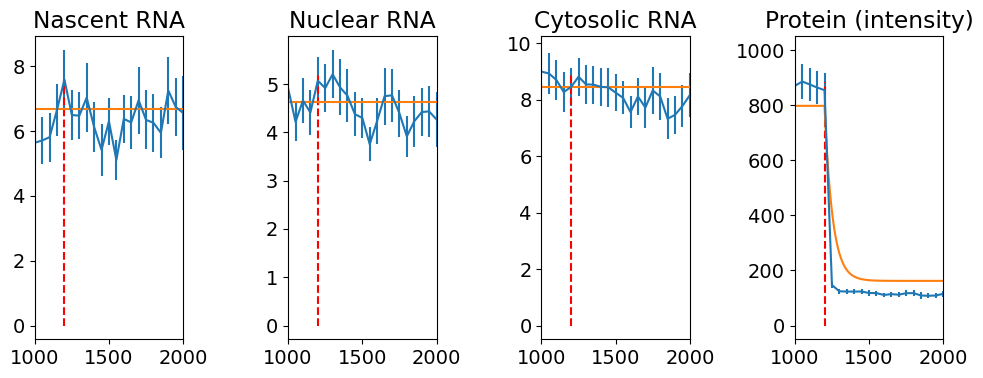

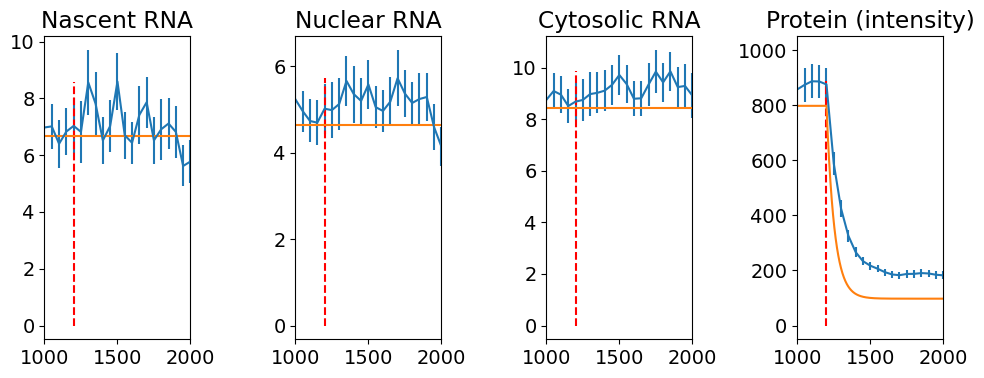

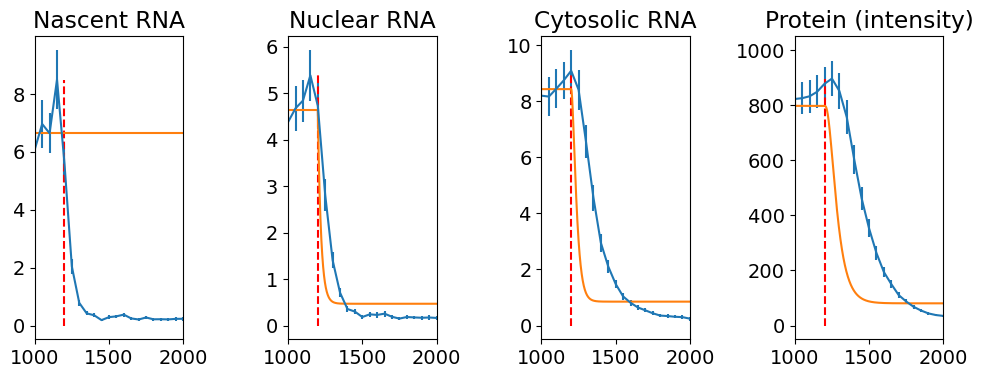

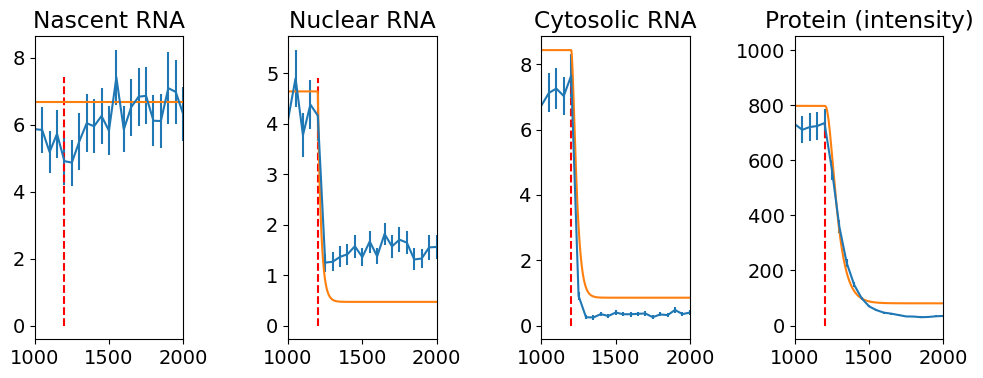

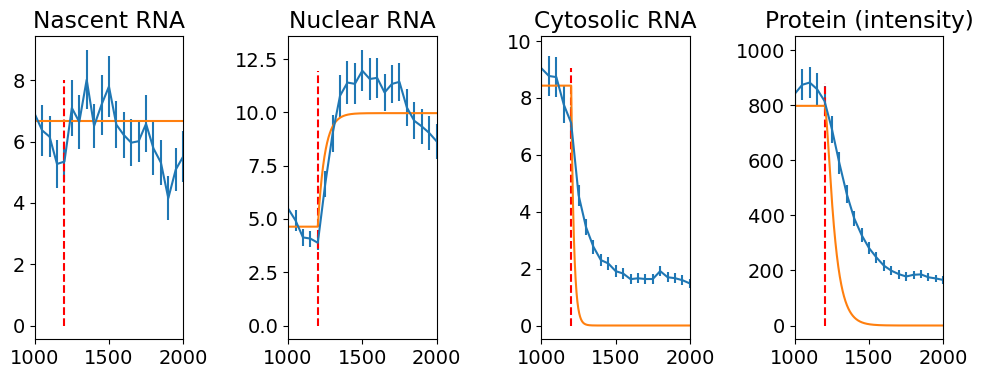

In [564]:
pathName = 'C:\\Users\\daria\\OneDrive - Politechnika Śląska\\QBio\\CourseMaterials\\uqbio2024\\UQbio2024_Team6\\TrueData'
print('Drug 0')
drug_number = 0 # use 0 for no drug! 0,2,4,7,10
compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path=pathName,
                    model='ODE',ntraj=10)

print('Drug 10')
drug_number = 10 # use 0 for no drug! 0,2,4,7,10
compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path=pathName,
                    model='ODE',ntraj=10)

print('Drug 4')
drug_number = 4 # use 0 for no drug! 0,2,4,7,10
compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path=pathName,
                    model='ODE',ntraj=10)

print('Drug 6')
drug_number = 6 # use 0 for no drug! 0,2,4,7,10
compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path=pathName,
                    model='ODE',ntraj=10)

print('Drug 7')
drug_number = 7 # use 0 for no drug! 0,2,4,7,10
compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path=pathName,
                    model='ODE',ntraj=10)

print('Drug 2')
drug_number = 2 # use 0 for no drug! 0,2,4,7,10
compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path=pathName,
                    model='ODE',ntraj=10)

In [565]:
# read csv files for Drug 2 1000nM, drug 4 1000nM, drug 6 1000nM, drug 7 1000nM, drug 10 1000nM, and no drug
df_Drug2_1000nM = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug2_1000nM_DesignResults.csv')
df_Drug4_1000nM = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug4_1000nM_DesignResults.csv')
df_Drug6_1000nM = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug6_1000nM_DesignResults.csv')
df_Drug7_1000nM = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug7_1000nM_DesignResults.csv')
df_Drug10_1000nM = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\Drug10_1000nM_DesignResults.csv')
df_NoDrug = pd.read_csv(r'C:\Users\daria\OneDrive - Politechnika Śląska\QBio\CourseMaterials\uqbio2024\UQbio2024_Team6\TrueData\NoDrug_DesignResults.csv')
  

In [570]:

# concentration protein data in 1000 Time (Cyto_Intensity_1) mean
protein_1000_time = df_Drug2_1000nM[df_Drug2_1000nM['Time'] == 1000]['Cyto_Intensity_1'].mean()
protein_2000_time = df_Drug2_1000nM[df_Drug2_1000nM['Time'] == 2000]['Cyto_Intensity_1'].mean()

g=(protein_1000_time-protein_2000_time)/protein_1000_time

vitality_1000_time = df_Drug2_1000nM[df_Drug2_1000nM['Time'] == 1000]['is_cell_vital'].mean()
vitality_2000_time = df_Drug2_1000nM[df_Drug2_1000nM['Time'] == 2000]['is_cell_vital'].mean()

f=(vitality_1000_time-vitality_2000_time)/vitality_1000_time

Di=[100,300,1000,3000,10000]

J= (g+f)/ (1 + sum(Di))

print(g)
print(f)
print(J)


# Create df for all drugs with g, f, sum Di and J


0.8557678921136408
0.26562500000000006
1001.1213928921136
